<a href="https://colab.research.google.com/github/dcastf01/creating_adversarial_images/blob/main/Create_adversarial_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Introduccion

Notebook para la creación de imágenes adversariales para un estudio que se está realizando en el Vrain

Es útil usar el siguiente video para la creación de nuestras imagenes adversariales

El modelo que se va a utilizar es el Nasnet

In [ ]:
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
if 'google.colab' in sys.modules: # Colab-only Tensorflow version selector
  %tensorflow_version 2.x
  
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy for hardware
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.master())  
elif len(gpus) > 0:
  #strategy = tf.distribute.MirroredStrategy(gpus) # this works for 1 to multiple GPUs
  print('Running on ', len(gpus), ' GPU(s) ')
  strategy=tf.distribute.OneDeviceStrategy(gpus[0])
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')

# How many accelerators do we have ?
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Tensorflow version 2.4.0
Running on  1  GPU(s) 
Number of accelerators:  1


In [ ]:
!nvidia-smi

Sun Dec 27 09:04:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    29W /  70W |    227MiB / 15079MiB |      2%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import requests

def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                print(chunk)
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"
   #URL=" https://docs.google.com/open?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

In [ ]:
%%capture
set_image_to_create_adversarial=True  #@param {type:"boolean"} 

if set_image_to_create_adversarial:
  file_id="1QA2HeOxusHicdbUxg54M8PG2GorB8ukG"
  destination="ILSVRC2012_val_5.zip"
  download_file_from_google_drive(file_id, destination)


label_id="1PKH4QWZe_VCOhu19oOhbV9z-YKrKACO7"
destination_label_id="/content/label.txt"
download_file_from_google_drive(label_id, destination_label_id)

label_real_name="1sxe3eunq5U4EwsHlLaeRmwcnaZjCEcnh"
destination_label_real_name="/content/name_real_label.json"
download_file_from_google_drive(label_real_name, destination_label_real_name)

In [ ]:
%%capture 
!mkdir data
!unzip /content/ILSVRC2012_val_5.zip  -d data

#Define labels

In [ ]:
import json
relation_classid_classname="/content/name_real_label.json"
relation_file_classid="/content/label.txt"
def get_dictionary_with_real_class():
  path_json_real_label=relation_classid_classname #el json es el bueno
  real_class_prev=json.loads(open(path_json_real_label).read())
  real_class=dict()
  for k in real_class_prev:
    real_class[int(k)]=real_class_prev[k][1] #dictionary key:number value:string
  return real_class


def get_all_labels(file_path_map):

  #file_path_map="/content/ILSVRC2012_validation_map_real.txt"
  conjunto_name_and_label = [l.strip() for l in open(file_path_map).readlines()]
  names=list()
  labels=list()
  for conjunto in conjunto_name_and_label:
    names_and_labels=conjunto.split(" ")
    names.append(names_and_labels[0])
    labels.append(names_and_labels[1])
  return dict(zip(names, labels))

def get_idclass_from_filename(filename):
  return int(dictionary_filename_idclass[filename])
def get_nameclass_from_idclass(idclass):
  return dictionary_idclass_nameclass[int(idclass)]


In [ ]:

dictionary_filename_idclass=get_all_labels(relation_file_classid)
dictionary_idclass_nameclass=get_dictionary_with_real_class()

#Create model

In [ ]:
model_choice=tf.keras.applications.nasnet
preproces_input=model_choice.preprocess_input
decode_predictions=model_choice.decode_predictions
model = tf.keras.applications.NASNetLarge(include_top=True,
                                                     weights='imagenet')

359751680/359748576 [==============================] - 3s 0us/step


In [ ]:
model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 165, 165, 96) 0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

#create Dataset

In [ ]:
import pathlib

In [ ]:
idxsubset=1 #@param {type:"slider", min:1, max:5, step:1}
examples=1000 #@param integer
inpath="/content/data"
outpath_base="result_adversarial"
# Imagenet_root=pathlib.Path(inpath)
# list_ds = tf.data.Dataset.list_files(str(Imagenet_root/'*'))
imgurls= !ls -1 "{inpath}"
imgurls=[correct_format for correct_format in imgurls ]
n_total=len(imgurls)
idx_initial=examples*(idxsubset-1)
idx_final=examples*idxsubset
subset_image=imgurls[idx_initial:idx_final]
n_subset=len(subset_image)

In [ ]:
def get_image(filepath):
  image=tf.io.read_file(filepath,)
  image=tf.io.read_file("data/"+filepath,)
  image = tf.cast(tf.io.decode_jpeg(image,channels=3),tf.float32)
  images_preproces=preproces_input(image,)
  image=tf.image.resize(image,[331,331])
  images_preproces=tf.image.resize(images_preproces,[331,331])

  return tf.cast(image,tf.float32), images_preproces,filepath


In [ ]:
list_ds=tf.data.Dataset.from_tensor_slices(subset_image)

images_original=list_ds.map(get_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)
images_original=images_original.batch(1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


40960/35363 [==================================] - 0s 0us/step
[[('n03131574', 'crib', 0.5146548), ('n02804414', 'bassinet', 0.22953656), ('n03125729', 'cradle', 0.11637673), ('n04235860', 'sleeping_bag', 0.0057332255), ('n03188531', 'diaper', 0.003435855)]]


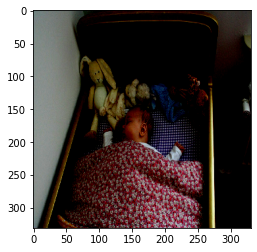

In [ ]:
for original_images,preprocess_image,filepath in images_original.take(1): #intentar sin el take para ver cuantos hace
  # plt.imshow(tf.cast(preprocess_image[0],tf.int32))
  plt.imshow(preprocess_image[0])
  predicts=model.predict(preprocess_image)
  print(decode_predictions(predicts))


In [ ]:
inp_layer=model.layers[0].input
out_layer=model.layers[-1].output
loss_object = tf.keras.losses.CategoricalCrossentropy()

def get_random_target_class_and_label(target_class=None):
  if not target_class:
    target_class=tf.random.uniform(shape=[], minval=0, maxval=999, dtype=tf.int64).numpy()

  target_prediction=tf.zeros_like(predicts)
  loss=out_layer[0,target_class]
  indices = tf.constant([[0,target_class]])
  updates = tf.constant([1])
  tensor = tf.zeros_like(predicts, dtype=tf.int32)
  label=tf.tensor_scatter_nd_update(tensor, indices, updates)
  return target_class,label

def setup_adversarial():
  target_class,label=get_random_target_class_and_label()
  adversarial_nameclass=get_nameclass_from_idclass(target_class)
  return target_class,label,adversarial_nameclass

def check_hacked_class_is_equal_original_class(hacked_image=None,original_nameclass=None,reset_setup=None):
          if reset_setup:
            return True
          else:
            prediction_hacked=model.predict(preproces_input(hacked_image))
            hacked_nameclass=decode_predictions(prediction_hacked)
            print("the hacked result is:",hacked_nameclass)
            if hacked_nameclass[0][0][1]==original_nameclass:
              return True
            else:
              return False

In [ ]:
def data_from_original_image(filename):
      original_idclass=get_idclass_from_filename(filename)
      original_nameclass=get_nameclass_from_idclass(original_idclass)
      original_prediction=model.predict(preprocess_image)
      class_confidence_original_img=original_prediction[0][original_idclass]
      return original_nameclass,class_confidence_original_img



Hago la predicción de la imagen original y luego calculo el coste para mi clase objetivo (en este caso el pañuelo) 

Después calculo la derivada entre el resultado del coste y la imagen original .
 
Y esta diferencia se la añado a la imagen original.
Además le obligó a que el rango de valores de la nueva imagen esté entre uno y menos uno

 Luego vuelvo a ejecutar lo mismo pero en lugar de la predicción de la imagen original lo hago con la imagen original modificada por la derivada. 
Y realizo estos pasos hasta que la predicción 

#Creating adversarial images
Y aquí esta el video donde lo he extraido
https://www.youtube.com/watch?v=-_A_AAxqzCg&ab_channel=DotCSV

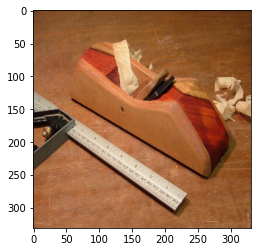

this is the image number: 64
the original class is: plane
the target class is: vault
target class: 0.00015338142
target class: 0.0006012415
target class: 0.00029557158
target class: 0.0004007025
target class: 0.0015859406
target class: 0.0032634193
target class: 0.005153629
target class: 0.019899268
target class: 0.1163822
target class: 0.012378225
the hacked result is: [[('n04523525', 'vault', 0.97674316), ('n03220513', 'dome', 0.0032981401), ('n03781244', 'monastery', 0.0019538838), ('n02787622', 'banjo', 0.00082478666), ('n03065424', 'coil', 0.0007346141)]]


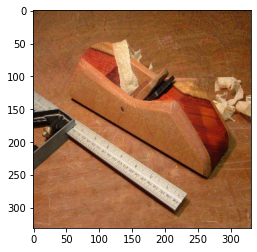

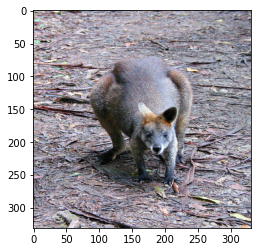

this is the image number: 65
the original class is: wallaby
the target class is: knot
target class: 8.165675e-05
target class: 0.0001248104
target class: 0.0002137926
target class: 0.0002981913
target class: 0.00012820616
target class: 0.0002637099
target class: 0.00023075276
target class: 0.00037898993
target class: 0.00049333356
target class: 0.0007191204


In [ ]:
from IPython.display import clear_output
from google.colab import files
i=0
experiments=[0.75,0.5,0.25,0.1,0.05,0.02,]
experiments_did=[0.75,0.5,0.25,0.05,0.02]
for pert_experiment in experiments:
  if pert_experiment in experiments_did:
    pass
  else:
    outpath=outpath_base+str(pert_experiment)
    filenamezip="adversarial"+str(pert_experiment)+".zip"
    !mkdir $outpath
    filenamelog='log_e_'+str(pert_experiment)+'.txt'
    with open(filenamelog, 'w') as the_file:


      for original_images,preprocess_image,filepath in images_original: #intentar sin el take para ver cuantos hace
        filename=filepath.numpy()[0][-28:].decode()

        original_nameclass,class_confidence_original_img=data_from_original_image(filename)
      
        hacked_class_equals_original_class=check_hacked_class_is_equal_original_class(reset_setup=True)
        while hacked_class_equals_original_class:
          plt.imshow(tf.cast(original_images[0],tf.int32))
          plt.show()
          print("this is the image number:",i)
          adversarial=tf.identity(preprocess_image)
          pert_max=pert_experiment #modificación maxima de los pixeles, como el valor esta normalizado a 1 esto siginifica que es el porcentaje que varia máximo de los pixeles
          max_pert=adversarial+pert_max
          min_pert=adversarial-pert_max

          target_class,label,adversarial_nameclass=setup_adversarial()

          # con esto nos aseguramos que no sale la clase objetivo
          while adversarial_nameclass==original_nameclass:
            target_class,label,adversarial_nameclass=setup_adversarial()
          print("the original class is:", original_nameclass)
          print("the target class is:",get_nameclass_from_idclass(target_class))
          cost=0
          number_iteration=0
          while cost<0.95:
            with tf.GradientTape() as tape:
              tape.watch(adversarial)
              prediction = model(adversarial)
              loss = loss_object(label, prediction)
              cost=prediction[0][target_class].numpy()
              if number_iteration//10==0:
                print("target class:",cost)

            if number_iteration>=250:
              clear_output()
              print("no convergia")
              print("this is the image number:",i)
              adversarial=tf.identity(preprocess_image)
              target_class,label,adversarial_nameclass=setup_adversarial()
              number_iteration=0
            else:
              number_iteration+=1
              gradient = tape.gradient(loss,  )
              adversarial-=gradient
              adversarial=tf.clip_by_value(adversarial, clip_value_min=min_pert, clip_value_max=max_pert)
              adversarial=tf.clip_by_value(adversarial, clip_value_min=-1, clip_value_max=1)
          
          
          hacked_image=tf.identity(adversarial)
          hacked_image+=1
          hacked_image*=127.5

          pattern_image=original_images-hacked_image
          hacked_class_equals_original_class=check_hacked_class_is_equal_original_class(hacked_image,original_nameclass)

        plt.imshow((tf.cast(hacked_image[0],tf.int32)))
        plt.show()
        new_filename=filename.split(".")[0]+".png"
        filepath=outpath+"/pert_eps_"+str(pert_max)+"_"+new_filename
        tf.keras.preprocessing.image.save_img(
              filepath, tf.cast(hacked_image[0],tf.int32).numpy(), data_format=None, file_format="PNG"
          )
        i+=1
        original_nameclass,class_confidence_original_img=data_from_original_image(filename)
        adversarial_nameclass=get_nameclass_from_idclass(target_class)
        txto=(filename+","+original_nameclass+","+str(class_confidence_original_img)+","+str(pert_max)+","+adversarial_nameclass+","+str(cost)+ ',pert_eps_'+str(pert_max)+'_'+new_filename+"\n")
        
        
        the_file.write(txto)
        if i%2==0:
          clear_output()

    commandfolderextract=outpath+"/*"
    !zip $filenamezip $filenamelog $commandfolderextract
    
    files.download(filenamezip) 


[[('n03594734', 'jean', 0.9837373), ('n03223299', 'doormat', 0.0009703491), ('n02892201', 'brass', 0.0008545108), ('n04356056', 'sunglasses', 0.00049088564), ('n02788148', 'bannister', 0.0004154133)]]


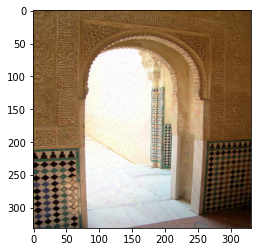

In [ ]:
plt.imshow((tf.cast(hacked_image[0],tf.int32)))
predicts=model.predict(preproces_input(hacked_image))
print(decode_predictions(predicts))

In [ ]:
tf.keras.preprocessing.image.save_img(
              "a", tf.cast(hacked_image[0],tf.int32).numpy(), data_format=None, file_format="PNG"
          )

[[('n03788195', 'mosque', 0.46172845), ('n04486054', 'triumphal_arch', 0.2227458), ('n03877845', 'palace', 0.04742627), ('n03998194', 'prayer_rug', 0.045533296), ('n04523525', 'vault', 0.036782406)]]


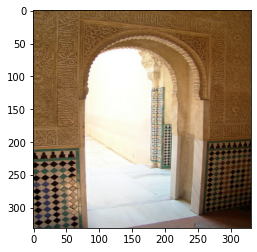

In [ ]:
plt.imshow(tf.cast(original_images[0],tf.int32))
predicts=model.predict(preproces_input(original_images))
print(decode_predictions(predicts))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[('n01930112', 'nematode', 0.13859053), ('n03196217', 'digital_clock', 0.10477607), ('n03729826', 'matchstick', 0.06530988), ('n03590841', "jack-o'-lantern", 0.04280297), ('n03666591', 'lighter', 0.025853973)]]


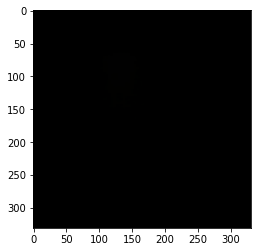

In [ ]:
plt.imshow((tf.cast(preprocess_image[0],tf.int32)))
predicts=model.predict(preproces_input(preprocess_image))
print(decode_predictions(predicts))